In [1]:
# System
import os
from collections import defaultdict, Counter
import csv
import re
import progressbar

# Data Analysis
import pandas
import tabulate
import seaborn
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl

# From imports
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Short hack for display of images in jupyter notebook

from IPython.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

In [2]:
FIGS_DIR = "figs"
def save_figure(fig, ext=".png"):
    """Stores @p fig at `figs/fig.@ext`"""
    tgt_dir = os.path.join(DATA_SOURCE, FIGS_DIR)
    tgt = os.path.join(tgt_dir, fig + ext)    
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    print(f"Saving to {tgt}")
    if ext == ".png":
        plt.savefig(tgt, backend="cairo", bbox_inches="tight", pad_inches=0.2)
    elif ext == '.pdf':
        plt.savefig(tgt, format='pdf', bbox_inches="tight", pad_inches=0.2)
    else:
        plt.savefig(tgt, bbox_inches="tight", pad_inches=0.2)

In [3]:
DATA_DIR = "./data/"
for experiment_dir in os.listdir(DATA_DIR):
    full_path = os.path.join(DATA_DIR, experiment_dir)
    if os.path.isdir(full_path):
        print(f'DATA_SOURCE = "{full_path}"')

DATA_SOURCE = "./data/experiments-09-18"
DATA_SOURCE = "./data/experiments-09-19"
DATA_SOURCE = "./data/experiments-09-21"
DATA_SOURCE = "./data/experiments-09-23"
DATA_SOURCE = "./data/experiments-09-25-concat"
DATA_SOURCE = "./data/experiments-09-26-partial-testing"
DATA_SOURCE = "./data/experiments-09-27"
DATA_SOURCE = "./data/experiments-09-29-new-mata"
DATA_SOURCE = "./data/experiments-09-30-parsing"
DATA_SOURCE = "./data/experiments-10-01-mata-union"
DATA_SOURCE = "./data/experiments-10-02"
DATA_SOURCE = "./data/experiments-10-02-automata"
DATA_SOURCE = "./data/experiments-10-02-parsing"
DATA_SOURCE = "./data/experiments-10-04"
DATA_SOURCE = "./data/experiments-10-04-sim"
DATA_SOURCE = "./data/experiments-10-05-email-filter"
DATA_SOURCE = "./data/experiments-10-05-email-filter-2"
DATA_SOURCE = "./data/experiments-10-05-presburger"
DATA_SOURCE = "./data/experiments-10-05-presburger-2"
DATA_SOURCE = "./data/experiments-10-06"
DATA_SOURCE = "./data/experiments-10-07"
DATA_SOURCE = "

In [4]:
DATA_SOURCE = "./data/experiments-10-10-full"

## Creating DataFrame

In [5]:
ERR = 60
TIMEOUT = 60

def to_operation(src, lang):
    op = src.split('-')[-1]
    if 'runtime' in op:
        return 'runtime'
    elif 'overall' in op:
        return 'overall'
    elif 'interpretation' in op:
        return 'interpretation'
    elif 'deter' in op:
        return 'determization'
    elif 'minterm' in op:
        return 'minterm'
    elif 'reduce' in op:
        return 'reduce'
    elif 'inter' in op:
        return 'intersection'
    elif 'union' in op or 'uni' in op:
        return 'union'
    elif ('construction' in op and lang != 'c++') or 'parsing' in op:
        return 'parsing'
    elif ('construction' in op and lang == 'c++') or 'conversion' in op:
        return 'transform'
    elif 'concat' in op:
        return 'concatenation'
    elif 'result' in op:
        return 'result'
    elif 'inclusion_check' == op or 'inclusion' == op:
        return 'inclusion'
    elif 'emptiness_check' == op or 'emptiness' == op:
        return 'emptiness'
    elif 'compl' == op or 'complementation' == op or 'complement' == op:
        return 'complement'
    elif 'trim' in op:
        return 'trim'
    print(f"{src} unhandled")
    assert False

def to_tool_and_lang(tool):
    if 'mata-bin' in tool or 'stats' in tool:
        return None, None
    elif 'mata-0.111' in tool:
        return "mata-0.111", "c++"
    elif 'mata-0.112' in tool:
        return "mata-0.112", "c++"
    elif 'mata-0.113' in tool:
        return "mata-0.113", "c++"
    elif 'mata-sim' in tool:
        return "mata-sim", "c++"
    elif 'mata-old' in tool:
        return "mata-old", "c++"
    elif 'awali' in tool:
        return 'awali', 'c++'
    elif 'mona' in tool:
        return 'mona', 'c++'
    elif 'vata' in tool:
        return 'vata', 'c++'
    elif 'java-brics' in tool:
        return 'brics', 'java'
    elif 'java-automata' in tool:
        return '(j)alib', 'java'
    elif 'pyfado' in tool:
        return 'fado', 'python'
    elif 'pyautomata-lib' in tool:
        return '(py)alib', 'python'
    elif 'pymata' in tool:
        return '(py)mata', 'python'
    elif 'automata' in tool:
        return 'automata', 'c#'
    elif 'mata' in tool:
        return 'mata', 'c++'
    print(f"{tool} unhandled")
    assert False

def to_bench(bench, src):
    if 'automata_inclusion' in bench:
        return 'aut_inclusion'
    elif 'comb/ere' in bench:
        return 'bc_ere'
    elif ('cox/diff' in bench or 'cox/inter' in bench) and 'union' in src :
        return 'bc_union'
    elif ('cox/diff' in bench or 'cox/inter' in bench) and 'cox-inter' in src :
        return 'bc_inter'
    elif ('cox/diff' in bench or 'cox/inter' in bench) and 'cox-diff' in src :
        return 'bc_cox_diff'
    elif 'email_filter' in bench:
        return 'email_filter'
    elif 'z3-noodler' in bench:
        if 'concat' in src:
            return 'z3_noodler_concat'
        elif 'intersect' in src:
            return 'z3_noodler_intersect'
        else:
            return 'z3_noodler'
    elif 'presburger-explicit' in bench:
        return 'presburger-explicit'
    elif 'presburger' in bench:
        return 'presburger'
    elif 'intersect' in bench:
        return 'bc_inter' if 'union' not in src else 'bc_union'
    print(f"{bench} unhandled")
    assert False

def to_value(val):
    val = val.strip()
    try:
        return float(val)
    except ValueError:
        pass
    if val in ['EMPTY', "NOT EMPTY"]:
        return val
    elif val in ('false', 'False'):
        return 'false'
    elif val in ('true', 'True'):
        return 'true'
    elif val == 'ERR':
        return 'ERR'
    elif val == 'MISSING':
        return numpy.NAN
        #return TIMEOUT
    elif val == 'TIMEOUT' or val == 'TO':
        return TIMEOUT
    print(f"{val} unhandled")
    assert False

In [6]:
HEADERS = ["bench", "input", "tool", "lang", "op", "time"]
TIMEOUT = 60
TIMEOUT_REGEX = re.compile("timeout-(\d+)")
processed = defaultdict(set)
op_map = defaultdict(list)
bench_map = defaultdict(set)

ignores = (
    ("mona", "bc_ere"),
    ("mona", "bc_intersect_union"),
    ("mona", "bc_intersect"),
    ("mona", "email_filter"),
    ("mona", "presburger"),
    ("mona", "z3_noodler_intersect"),
)
ignored_tools = (
    '(py)mata',
)

def to_pandas(src_dir):
    global TIMEOUT
    data = []
    for csv_source in progressbar.progressbar(os.listdir(src_dir)):
        if csv_source.endswith('.csv'):
            if timeout := TIMEOUT_REGEX.search(csv_source):
                TIMEOUT = int(timeout.group(1))
            with open(os.path.join(src_dir, csv_source), 'r', newline='') as csvfile:
                try:
                    csv_reader = csv.reader(csvfile, delimiter=';')
                    head = next(csv_reader)
                    for row in csv_reader:
                        bench = to_bench(row[0], csv_source) # bench
                        bench_map[(row[0], bench)].add(csv_source)
                        inputs = row[0] # inputs
                        for i, val in enumerate(row[1:], 1):
                            tool, lang = to_tool_and_lang(head[i]) # tool, lang
                            if not tool or tool in ignored_tools:
                                continue
                            op = to_operation(head[i], lang) # op
                            op_map[op].append(head[i])
                            val = to_value(val)
                            if (tool, bench) in ignores:
                                continue
                            data.append([bench, inputs, tool, lang, op, val])
                except StopIteration:
                    pass
    return pandas.DataFrame(data, columns=HEADERS)
df = to_pandas(DATA_SOURCE)
print(df)

100% (29 of 29) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


                    bench                                              input  \
0           aut_inclusion  /home/experiments/nfa-bench/benchmarks/automat...   
1           aut_inclusion  /home/experiments/nfa-bench/benchmarks/automat...   
2           aut_inclusion  /home/experiments/nfa-bench/benchmarks/automat...   
3           aut_inclusion  /home/experiments/nfa-bench/benchmarks/automat...   
4           aut_inclusion  /home/experiments/nfa-bench/benchmarks/automat...   
...                   ...                                                ...   
505995  z3_noodler_concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
505996  z3_noodler_concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
505997  z3_noodler_concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
505998  z3_noodler_concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   
505999  z3_noodler_concat  /home/experiments/nfa-bench/benchmarks/z3-nood...   

            tool  lang              op 

In [7]:
data = {
    'bench': [],
    'input': [],
    'tool': [],
    'lang': [],
    'op': [],
    'time': []
}
def to_float(val, default=0):
    vals = list(val)
    if val.empty:
        if default == None:
            print(f"{val=}, {vals=}")
            assert False
        return default
    if len(vals) != 1:
        print(f"{vals=}")
        assert False
    try:
        return float(vals[0])
    except:
        return 0 if str(vals[0]) not in ('ERR', 'TIMEOUT') else TIMEOUT
for grp, series in df.groupby(['bench', 'input', 'tool']):
    data['bench'].append(grp[0])
    data['input'].append(grp[1])
    data['tool'].append(grp[2])
    data['lang'].append(list(series['lang'])[0])
    data['op'].append('fair-overall')

    pyco_runtime = list(series[series['op'] == 'runtime']['time'])
    if len(pyco_runtime) != 1:
        print(f"{list(series.items())=}")
        print(f"{pyco_runtime=}")
        assert False
    if pyco_runtime[0] == TIMEOUT or pyco_runtime[0] == 'ERR':
        data['time'].append(TIMEOUT)
        continue
        
    
    runtime = to_float(series[series['op'] == 'overall']['time'], None)
    parsing = to_float(series[series['op'] == 'parsing']['time'], 0)
    transform = to_float(series[series['op'] == 'transform']['time'], 0)
    minterm = to_float(series[series['op'] == 'minterm']['time'], 0)
    fair_runtime = runtime - parsing - transform - minterm
    if grp[2] == 'mona':
        data['time'].append(runtime)
    else:
        data['time'].append(fair_runtime)
ddf = pandas.DataFrame(data)
df = pandas.concat([df, ddf])

In [8]:
def sum_generator(series, timeout=None):
    """Cumulatively sums the @p series wrt @p timeout"""
    sum = 0
    series = sorted(
        [a if isinstance(a, float | int) else numpy.NAN for a in series['time']],
        key = lambda x: float('inf') if numpy.isnan(x) else x
    )
    for num in sorted(series):
        if numpy.isnan(num):
            yield None
        if timeout and num >= timeout:
            yield None
        else:
            sum += num
            yield sum

def nosum_generator(series, timeout=None):
    """Cumulatively sums the @p series wrt @p timeout"""
    series = sorted(
        [a if isinstance(a, float) or isinstance(a, int) else numpy.NAN for a in series['time']],
        key = lambda x: float('inf') if numpy.isnan(x) else x
    )
    for num in sorted(series):
        if numpy.isnan(num):
            yield None
        if timeout and num >= timeout:
            yield None
        else:
            yield num

In [9]:
tools = sorted(t for t in set(df['tool']))
tool_len = len(tools)
color_map = {
    t: c for (t, c) in zip(tools, mpl.colormaps['tab10'].resampled(tool_len).colors)
}
axis_scale = "symlog"

In [10]:
def disable_axis(axes, i, item_per_row=3):
    axes[i // item_per_row, i % item_per_row].set(xlabel=None)
    axes[i // item_per_row, i % item_per_row].set(yticklabels=[])
    axes[i // item_per_row, i % item_per_row].set(xticklabels=[])
    axes[i // item_per_row, i % item_per_row].set(xticks=[])
    axes[i // item_per_row, i % item_per_row].set(yticks=[])
    axes[i // item_per_row, i % item_per_row].spines['top'].set_visible(False)
    axes[i // item_per_row, i % item_per_row].spines['bottom'].set_visible(False) 
    axes[i // item_per_row, i % item_per_row].spines['left'].set_visible(False) 
    axes[i // item_per_row, i % item_per_row].spines['right'].set_visible(False) 

def print_legend(axes, i, item_per_row=3, ncols=2):
    axes[i // item_per_row, i % item_per_row].legend(
        handles=[
            Line2D(
                [0], [0], color='w', marker='o', markerfacecolor=color_map[tool], label=f"{tool}", 
                markersize=10,
            )
            for tool in sorted(color_map.keys())
        ], ncols=ncols, loc='center', fontsize='14'
    ) 

### Final visualizations

Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-bench-sum-fair-overall.png
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-bench-sum-fair-overall.pdf


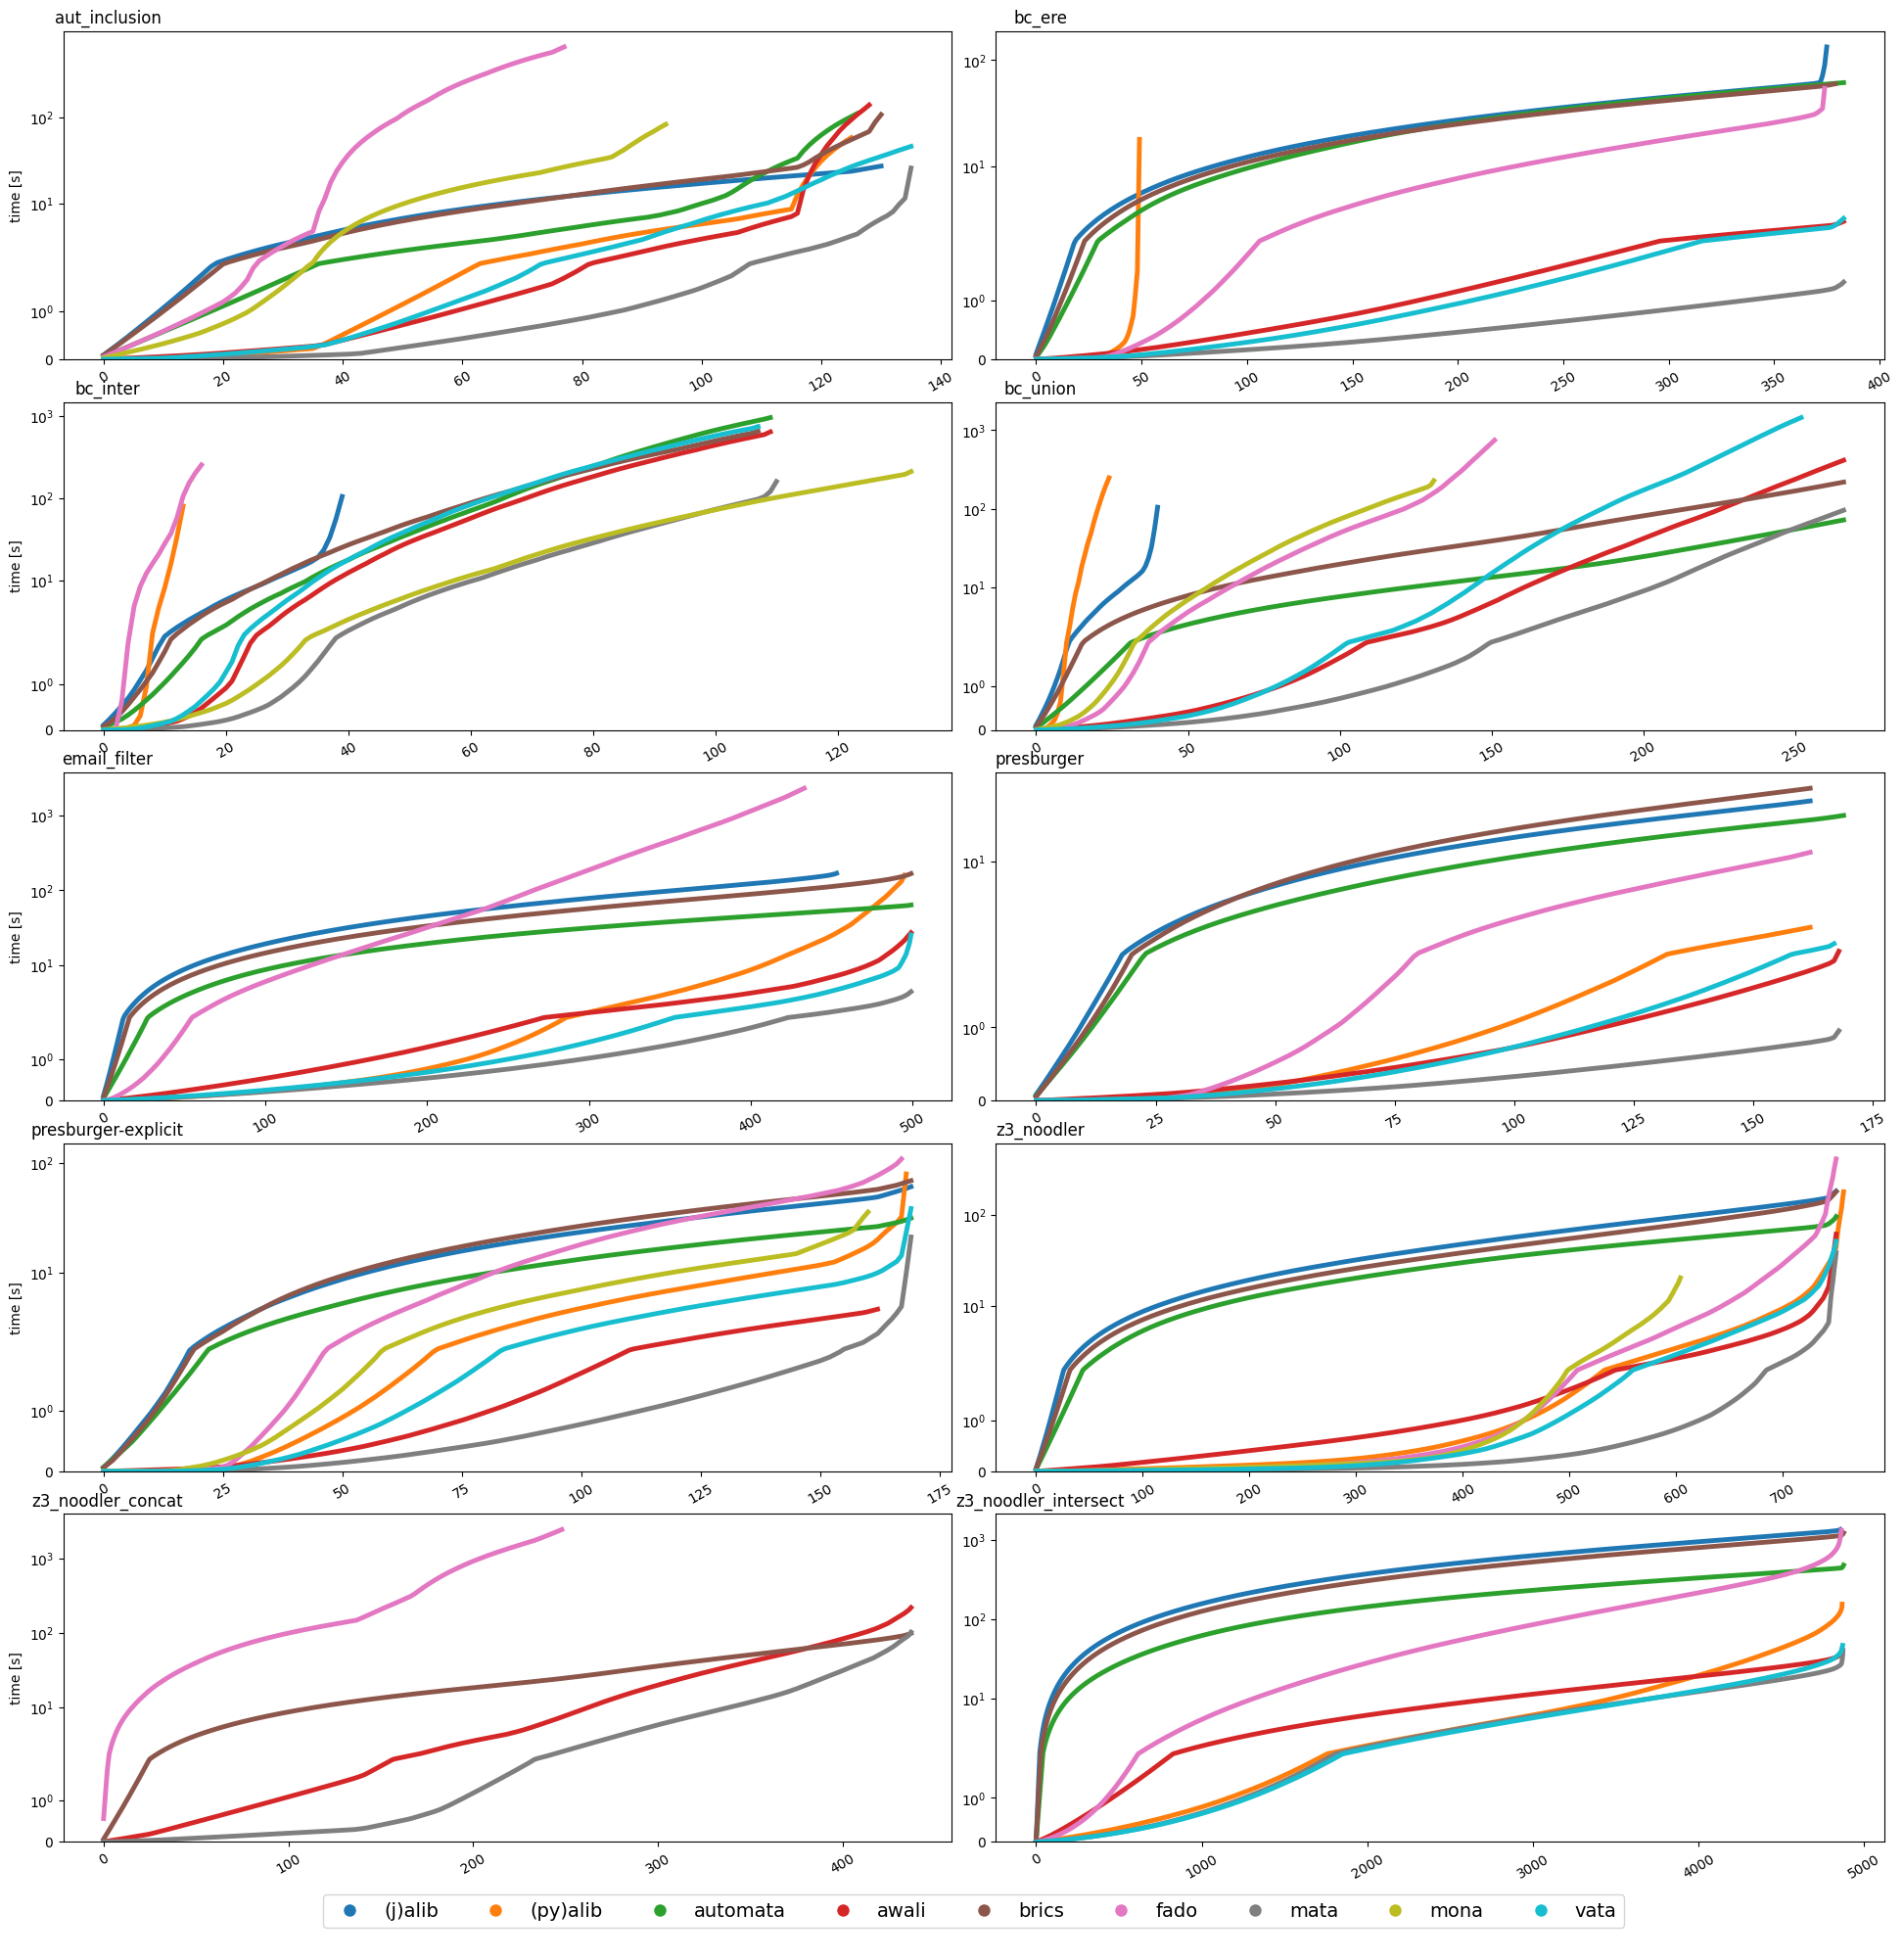

In [21]:
bench_list = sorted(list(set(list(df['bench']))))
item_no = len(bench_list)
item_per_row = 2
x_dim = item_no // item_per_row + 1
y_dim = min(item_no, item_per_row)

mosaic = """
  AB
  CD
  EF
  GH
  IJ
  KK
"""

mosaics = "ABCDEFGHIJK"
hr = [1, 1, 1, 1, 1, 0.2]
log = ""

for sum_op, sum_name in [
    (sum_generator, "sum"), 
    #(nosum_generator, "nosum")
]:
    for op in (
        #'runtime', 
        'fair-overall',
    ):
        #fig, ax = plt.subplots(x_dim, y_dim, figsize=(x_dim * 4, y_dim * 10))
        fig, ax = plt.subplot_mosaic(mosaic, figsize=(x_dim*4, y_dim*10), height_ratios=hr)
        plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.15, wspace=0.05)
        
        i = 0
        for grp in bench_list:
            series = df[df['bench'] == grp]
            series = series[series['op'] == op]
            grp_name = f"{grp}"
            k = mosaics[i]
            
            data = {}
            for tool, values in series.groupby('tool'):
                log += f"{grp=}:{tool=}\n"
                log += f"{sorted(list(values['time']))=}\n"
                data[tool] = list(sum_op(values, timeout=TIMEOUT))
                log += f"{data[tool]=}\n"
            log += "\n"
                
            g = seaborn.lineplot(
                #data, linewidth=3.5, palette=color_map, dashes="", ax=ax[i // item_per_row, i % item_per_row] if item_no > 1 else ax
                data, linewidth=3.5, palette=color_map, dashes="", ax=ax[k] if item_no > 1 else ax
            )

            g.legend([], [], frameon=False)
            g.set(yscale=axis_scale)
            g.set_xticklabels(g.get_xticklabels(), rotation=30)
            g.set_title(f"{grp}", x=0.05)
            if i % item_per_row == 0:
                g.set_ylabel("time [s]")
            if i // item_per_row == x_dim - 1:
                g.set_xlabel("benchmark")
            
            
            x_lim_min, x_lim_max = g.get_xlim()
            g.set_xlim((x_lim_min, x_lim_max))
            y_lim_min, y_lim_max = g.get_ylim()
            g.set_ylim((0, max(y_lim_min, y_lim_max)))
            
            i += 1

        ax["K"].set(xlabel=None)
        ax["K"].set(yticklabels=[])
        ax["K"].set(xticklabels=[])
        ax["K"].set(xticks=[])
        ax["K"].set(yticks=[])
        ax["K"].spines['top'].set_visible(False)
        ax["K"].spines['bottom'].set_visible(False) 
        ax["K"].spines['left'].set_visible(False) 
        ax["K"].spines['right'].set_visible(False) 
        ax["K"].legend(
            handles=[
                Line2D(
                    [0], [0], color='w', marker='o', markerfacecolor=color_map[tool], label=f"{tool}", 
                    markersize=10,
                )
                for tool in sorted(color_map.keys())
            ], ncols=10, loc='upper center', fontsize='14'
        ) 
        save_figure(f"paper-cactus-plot-per-bench-{sum_name}-{op}")
        save_figure(f"paper-cactus-plot-per-bench-{sum_name}-{op}", ext=".pdf")

In [12]:
with open('log', 'w') as lh:
    lh.write(log)

available: ['complement', 'concatenation', 'determization', 'emptiness', 'fair-overall', 'inclusion', 'interpretation', 'intersection', 'minterm', 'overall', 'parsing', 'result', 'runtime', 'transform', 'trim', 'union']
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-operation-sum.png
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-operation-sum.pdf
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-operation-nosum.png
Saving to ./data/experiments-10-10-full/figs/paper-cactus-plot-per-operation-nosum.pdf


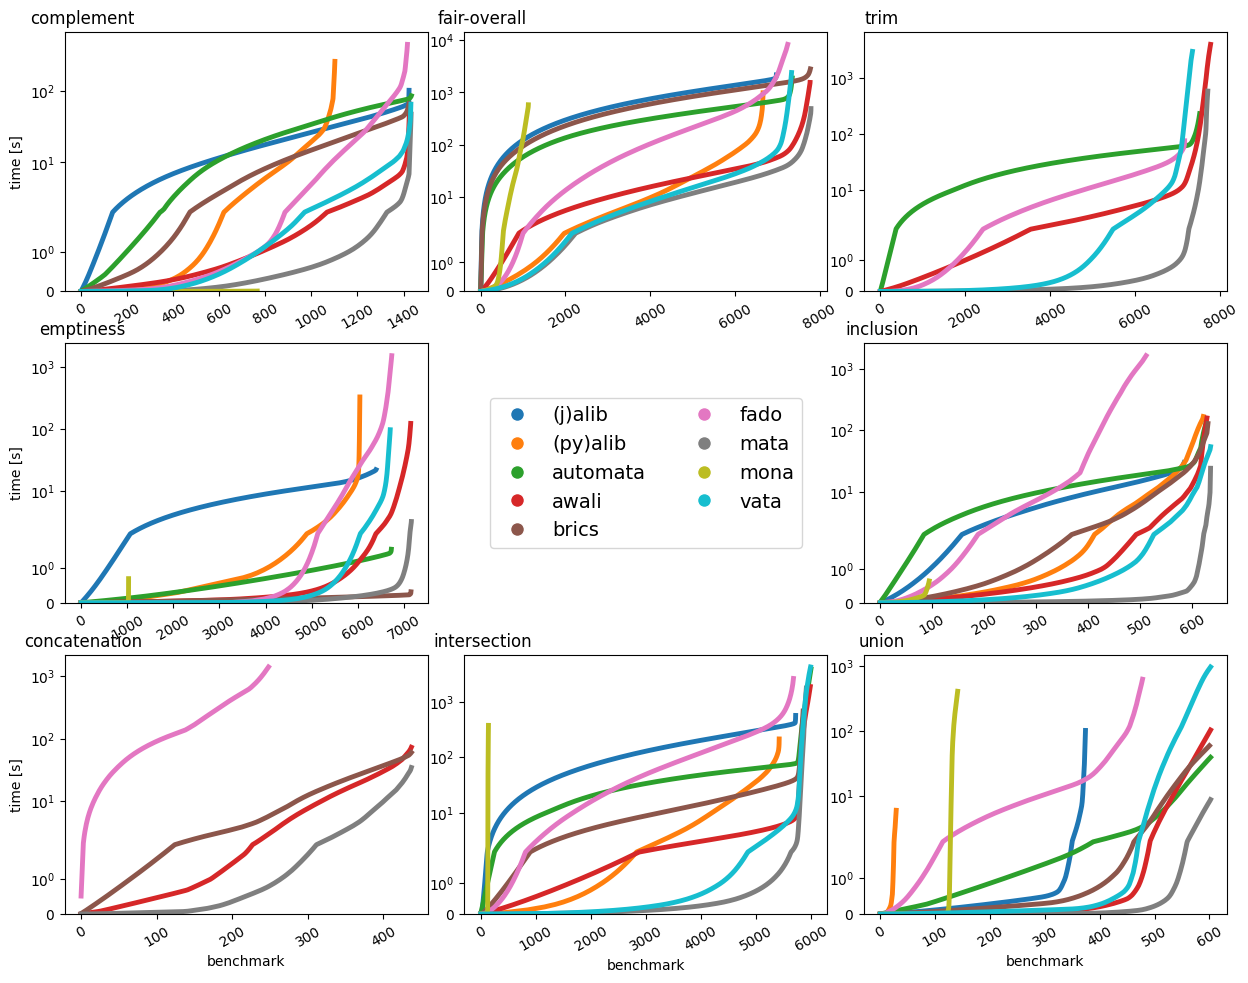

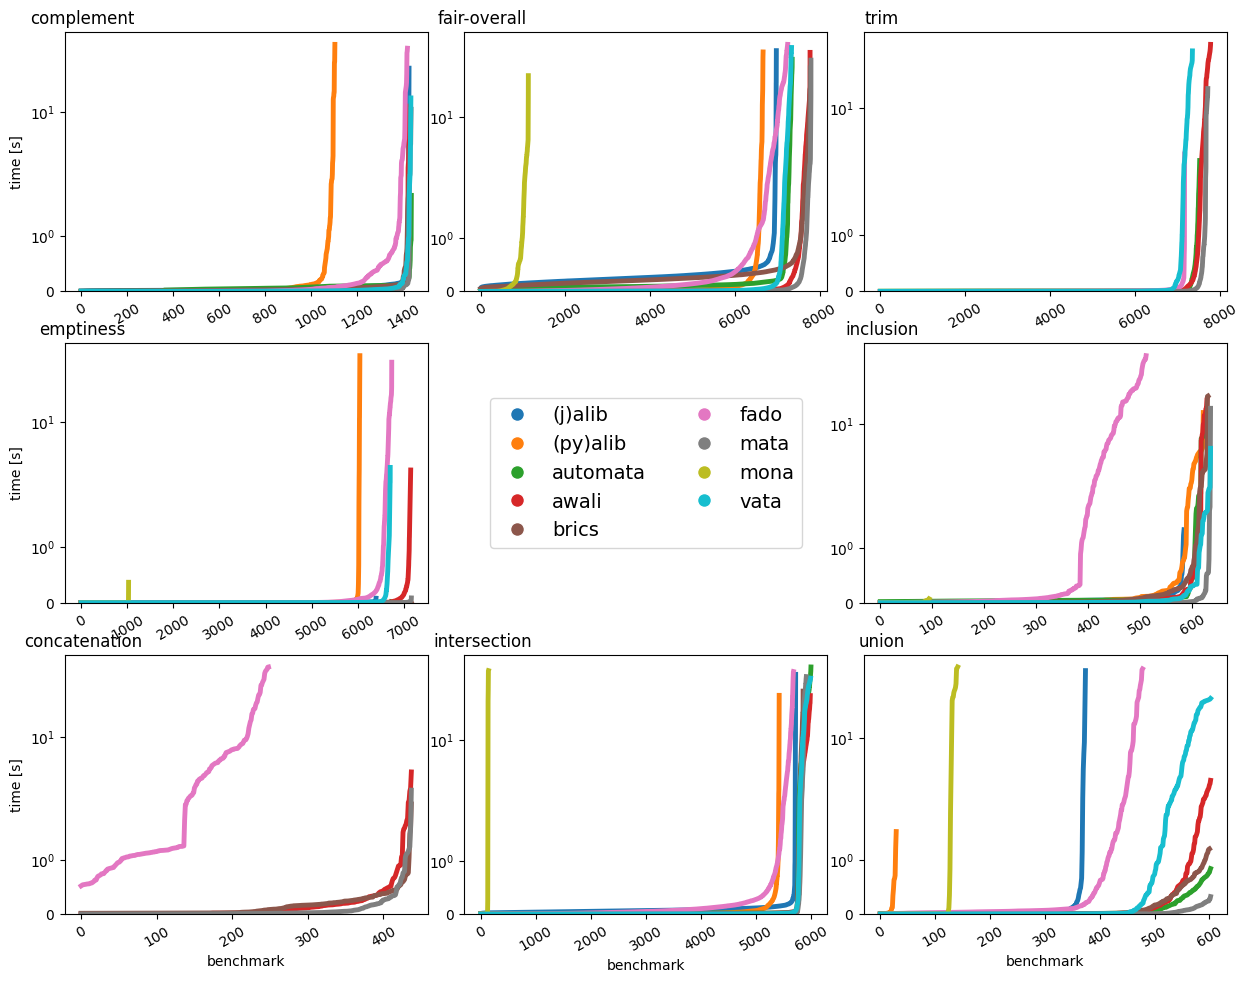

In [13]:
op_list = sorted(list(set(list(df['op']))))
print(f"available: {op_list}")
op_list = [
    'complement',    'fair-overall',      'trim', 
    'emptiness',                     'inclusion',
    'concatenation', 'intersection', 'union'
    #'determization',  
    #'overall', 
    #'interpretation', 
    #'minterm', 
    #'parsing', 'reduce', 
    #'runtime', 'transform', 
]
item_no = len(op_list)
x_dim = item_no // 3 + 1
y_dim = min(item_no, 3)


for sum_op, sum_name in [(sum_generator, "sum"), (nosum_generator, "nosum")]:
    fig, ax = plt.subplots(x_dim, y_dim, figsize=(x_dim * 5, y_dim * 3))
    plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.2, wspace=0.10)
    
    i = 0
    for grp in op_list:
        series = df[df['op'] == grp]
        grp_name = f"{grp}"
        
        data = {}
        for tool, values in series.groupby('tool'):
            data[tool] = list(sum_op(values, timeout=TIMEOUT))
        
        g = seaborn.lineplot(
            data, linewidth=3.5, palette=color_map, dashes="", ax=ax[i // 3, i % 3] if item_no > 1 else ax
        )
        g.legend([], [], frameon=False)
        
        g.set(yscale=axis_scale)
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        g.set_title(f"{grp}", x=0.05)
        if i % 3 == 0:
            g.set_ylabel("time [s]")
        if i // 3 == 2:
            g.set_xlabel("benchmark")
        
        #seaborn.move_legend(g, "upper left", bbox_to_anchor=(0., 1), frameon=False)
        x_lim_min, x_lim_max = g.get_xlim()
        g.set_xlim((x_lim_min, x_lim_max))
        y_lim_min, y_lim_max = g.get_ylim()
        g.set_ylim((0, max(y_lim_min, y_lim_max)))
    
        i += 1
        if i == 4: 
            i += 1
    disable_axis(ax, 4)
    print_legend(ax, 4)
    save_figure(f"paper-cactus-plot-per-operation-{sum_name}")
    save_figure(f"paper-cactus-plot-per-operation-{sum_name}", ext=".pdf")

### Rest of the visualizations

In [14]:
def to_table(df, rows, aggregation, trim_rows=False, trimsize=5):
    tools = ['mata', 'mata-0.111', 'mata-0.112', 'mata-0.113', 'mata-old', 'mata-sim', 'awali', 'mona', 'vata',  'automata', 'brics', '(j)alib', 'fado', '(py)alib', '(py)mata']
    tools = [t for t in tools if t in set(df['tool'])]
    data = {
        grp: [grp[:trimsize] if trim_rows else grp] + ['-' for i in range(len(tools))] for grp in set(df[rows]) if grp != 'result' and 'result' not in grp
    }
    for grp, series in df.groupby([rows, 'tool'] if not isinstance(rows, list) else rows + ['tool']):
        if grp[0] == 'result' or 'result' in grp[0]:
            continue
        vals = aggregation(series['time'])
        data[grp[0]][tools.index(grp[1]) + 1] = ", ".join(vals)
    return tabulate.tabulate(
        sorted(data.values()), headers=[rows] + tools, tablefmt='latex'
    )

def to_printable_table(table, title):
    #table_len = len(table.split('\n')[1])
    #printable = title.center(table_len) + "\n"
    #printable += "-" * table_len + "\n"
    printable = table
    return printable

def print_table(table, title):
    printable = to_printable_table(table, title)
    print(printable)

def save_table(table, title, filename):
    tgt_dir = os.path.join(DATA_SOURCE, FIGS_DIR)
    tgt = os.path.join(tgt_dir, filename)    
    printable = to_printable_table(table, title)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    with open(tgt, 'w') as table_h:
        table_h.write(printable)
    print(f"Saved to {tgt}")
    

In [15]:
## Mean, Median Mean with timeouts/errors
def stats(series):
    times = [t for t in series if  (isinstance(t, float) or isinstance(t, int)) and t >= 0 and t < TIMEOUT]
    #timeouts = [t for t in series if ((isinstance(t, float) or isinstance(t, int)) and t >= TIMEOUT)]
    timeouts = [a for a in series if ((isinstance(a, float) or isinstance(a, int)) and (a >= TIMEOUT)) or a == 'ERR']

    times_with_timeout = [t if (isinstance(t, float) or isinstance(t, int)) and t >= 0 else TIMEOUT for t in series]
    
    mean = int(1000 *round(numpy.mean(times or [60]), 3))
    #first = int(1000 * round(numpy.quantile(times_with_timeout, 0.25), 3))
    first = int(1000 * round(numpy.quantile(times_with_timeout, 0.5), 3))
    #third = int(1000 * round(numpy.quantile(times_with_timeout, 0.75), 3))
    third = int(1000 * round(numpy.std(times_with_timeout), 3))

    if with_to:
        return (
            f"{len(timeouts)}",
            f"{mean}" if mean < TIMEOUT * 1000 else f"TO",
            f"{first}" if first < TIMEOUT * 1000 else f"TO",
            f"{third}" if third < TIMEOUT * 1000 else f"TO",
        )
    else:
        return (
            f"{mean}" if mean < TIMEOUT * 1000 else f"TO",
            f"{first}" if first < TIMEOUT * 1000 else f"TO",
            f"{third}" if third < TIMEOUT * 1000 else f"TO",
        )

with_to = False
table = to_table(df, 'op', stats)
print_table(table, "Average / 1st Quartile / 3rd Quartile")
print()
save_table(table, "Average / 1st Quartile / 3rd Quartile", "stats-per-op.tex")

\begin{tabular}{llllllllll}
\hline
 op             & mata           & awali         & mona            & vata           & automata       & brics            & (j)alib           & fado              & (py)alib          \\
\hline
 complement     & 33, 1, 10727   & 39, 2, 11439  & 0, 0, 22821     & 46, 4, 10831   & 60, 53, 10608  & 47, 25, 11623    & 72, 33, 11641     & 320, 3, 12430     & 237, 25, 26158    \\
 concatenation  & 79, 9, 236     & 166, 22, 402  & -               & -              & -              & 137, 35, 205     & -                 & 5651, 9554, 27888 & -                 \\
 determization  & -              & -             & -               & -              & -              & -                & -                 & 321, 17, 12429    & 111, 1, 17624     \\
 emptiness      & 0, 0, 9004     & 17, 0, 9359   & 1, 0, 24385     & 14, 0, 9797    & 0, 0, 9171     & 0, 0, 9235       & 3, 2, 13082       & 224, 0, 16389     & 54, 0, 18178      \\
 fair-overall   & 63, 4, 8658    & 200, 7, 

In [16]:
with_to = True
table = to_table(df[df['op'] == 'fair-overall'], 'bench', stats)
print_table(table, "TO / Average / 1st Quartile / 3rd Quartile")
print()
save_table(table, "TO / Average / 1st Quartile / 3rd Quartile", "stats-per-bench.tex")

\begin{tabular}{llllllllll}
\hline
 bench                & mata                 & awali                & mona                 & vata                 & automata             & brics                & (j)alib              & fado                    & (py)alib             \\
\hline
 aut\_inclusion        & 0, 190, 20, 1238     & 7, 1080, 35, 13412   & 41, 875, 576, 27163  & 0, 338, 54, 582      & 9, 872, 88, 14834    & 5, 821, 210, 11410   & 5, 208, 199, 11253   & 58, 8429, 21950, 26630  & 10, 461, 69, 15592   \\
 bc\_ere               & 0, 3, 3, 3           & 0, 8, 8, 5           & -                    & 0, 8, 8, 12          & 0, 160, 177, 45      & 4, 158, 151, 6076    & 8, 354, 162, 8860    & 9, 145, 74, 9108        & 334, 360, TO, 20088  \\
 bc\_inter             & 156, 1444, TO, 28977 & 157, 5842, TO, 27063 & 134, 1595, TO, 29238 & 159, 6900, TO, 26514 & 157, 8698, TO, 26128 & 159, 6051, TO, 26801 & 227, 2641, TO, 20723 & 250, 15024, TO, 12043   & 253, 5785, TO, 12410 \\
 bc\_union     

In [17]:
"""Spis tohle, az budes mit cas: vzit priklady, na kterych dojely vsechny rychle knihovny, mata, vata, brics, awali, automata.net, 
a spocitat sumarni cas. Pro pomalejsi knihovny to ani nepocitat. Pak se misto toho sumarniho casu muze vzti treba jeji cas/ cas maty,
cizm mata ma vsude 1 a ostatni nake vetsi cislo, a rika to opravdu neco o porovnani rychlosti.
"""
def some_fucking_stats(series):
    times_with_timeout = [t if (isinstance(t, float) or isinstance(t, int)) and t >= 0 else TIMEOUT for t in series]
    return sum(times_with_timeout)
def to_fucking_table(df, rows, aggregation, trim_rows=False, trimsize=5):
    tools = ['mata', 'mata-0.111', 'mata-0.112', 'mata-0.113', 'mata-old', 'mata-sim', 'awali', 'mona', 'vata',  'automata', 'brics', '(j)alib', 'fado', '(py)alib', '(py)mata']
    tools = [t for t in tools if t in set(df['tool'])]
    data = {
        grp: [grp[:trimsize] if trim_rows else grp] + ['-' for i in range(len(tools))] for grp in set(df[rows]) if grp != 'result' and 'result' not in grp
    }
    for grp, series in df.groupby([rows, 'tool'] if not isinstance(rows, list) else rows + ['tool']):
        if grp[0] == 'result' or 'result' in grp[0]:
            continue
        vals = aggregation(series['time'])
        data[grp[0]][tools.index(grp[1]) + 1] = vals
    
    for key, vals in data.items():
        data[key] = [vals[0]] + [
            f"{round(val / vals[1], 1):,}" if val != '-' else '-' for val in vals[1:]
        ]        
    return tabulate.tabulate(
        sorted(data.values()), headers=[rows] + tools, tablefmt='latex'
    )    
with_to = True
table = to_fucking_table(df[df['op'] == 'fair-overall'], 'bench', some_fucking_stats)
print_table(table, "Relative Speed")
print()
save_table(table, "TO / Average / 1st Quartile / 3rd Quartile", "stats-relative-per-bench.tex")

\begin{tabular}{lrrlllrlll}
\hline
 bench                &   mata &   awali & mona   & vata   & automata   &   brics & (j)alib   & fado    & (py)alib   \\
\hline
 aut\_inclusion        &      1 &    21.7 & 98.5   & 1.8    & 25.2       &    15.8 & 12.7      & 160.3   & 25.5       \\
 bc\_ere               &      1 &     2.3 & -      & 2.5    & 47.1       &   229.8 & 469.7     & 455.3   & 15,367.3   \\
 bc\_inter             &      1 &     1.1 & 0.9    & 1.1    & 1.1        &     1.1 & 1.4       & 1.6     & 1.6        \\
 bc\_union             &      1 &     4.3 & 86.7   & 23.8   & 0.8        &     2.3 & 142.3     & 79.6    & 153.8      \\
 email\_filter         &      1 &     6.1 & -      & 5.7    & 14.4       &    37.8 & 661.8     & 1,416.9 & 90.1       \\
 presburger           &      1 &     1   & -      & 2.0    & 0.4        &     7.5 & 7.4       & 7.1     & 6.9        \\
 presburger-explicit  &      1 &    20   & 27.1   & 1.8    & 1.5        &     3.3 & 2.9       & 10.8    & 6.6    

In [18]:
print("DONE")

DONE
